In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from astropy.io import fits
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt

# Rescale font sizes
rs = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25*rs
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22*rs
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22*rs
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

For a single break $dN/dF$ that has the form $A (F/F_b)^{-n_1}$ above the break, and $A (F/F_b)^{-n_2}$ below the break, we can determine an equivalent PS CDF for Florian to compare with.

In particular, assuming n1 > 1 and n2 < 1, then the total number of sources from the distribution is

$N = A F_b \left( \frac{1}{n_1-1} + \frac{1}{1-n_2} \right)$

If we divide $dN/dF$ by this, we obtain a pdf $p(F) = (1/N) dN/dF$ for the flux. We can then integrate this from 0 to $F$ to obtain the CDF for the flux, which is what Florian trains the neural net on. In detail, for $F < F_b$, we have

$C(F) = \frac{n_1-1}{n_1-n_2} \left( \frac{F}{F_b} \right)^{1-n_2}$

and for $F > F_b$,

$C(F) = 1-\frac{1-n_2}{n_1-n_2} \left( \frac{F}{F_b} \right)^{1-n_1}$

Note for $n_2 < 1$ we have $C(0)=0$, and for $n_1 > 1$, we have $C(\infty)=1$, as required.

# Scenario 1

I will digitize Silvia's scenario 1 and convert it to a dN/dF, and then CDF.

In [2]:
def dNdF(F, A, Fb, n1, n2):
    if F >= Fb:
        return A*(F/Fb)**(-n1)
    else:
        return A*(F/Fb)**(-n2)
    
dNdF = np.vectorize(dNdF)

def CDF(F, Fb, n1, n2):
    if F < Fb:
        return (n1-1.)/(n1-n2)*(F/Fb)**(1.-n2)
    else:
        return 1.-(1.-n2)/(n1-n2)*(F/Fb)**(1.-n1)
        
CDF = np.vectorize(CDF)

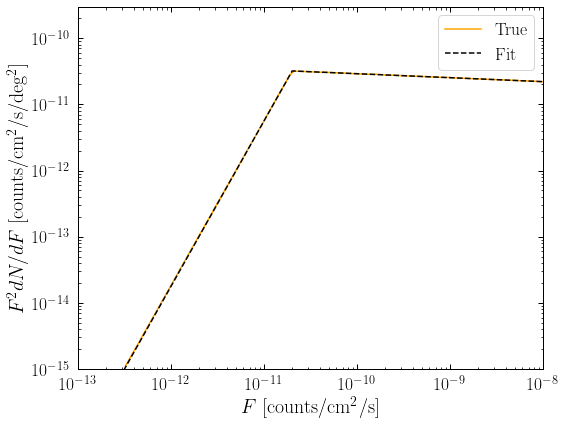

In [3]:
FsqdNdF1 = 10.**np.array([[-12.488549814972714,-14.95072086623594],[-12.45175094952318,-14.859686481859848],[-12.414949575202641,-14.766431746645313],[-12.37815133697086,-14.675952449978832],[-12.34398636793024,-14.596204849031482],[-12.288779706852594,-14.452252103005872],[-12.251980841403059,-14.361217718629778],[-12.215181348735774,-14.269628246544075],[-12.178384364939493,-14.180259125296814],[-12.141584872272208,-14.08866965321111],[-12.104784125169422,-13.995970005706187],[-12.067983378066634,-13.903270358201262],[-12.031183885399349,-13.811680886115559],[-11.994386274385317,-13.721756677158687],[-11.957586781718032,-13.630167205072985],[-11.920786034615245,-13.53746755756806],[-11.883985914730209,-13.445322997772745],[-11.84456057494848,-13.349570367864967],[-11.789356945423295,-13.208300545769138],[-11.752560588844764,-13.119486512231488],[-11.715759841741978,-13.026786864726564],[-11.678960976292444,-12.93575248035047],[-11.642163365278412,-12.845828271393598],[-11.605363245393375,-12.753683711598285],[-11.568565634379343,-12.663759502641412],[-11.510732394433209,-12.514995996465846],[-11.47393666507243,-12.426737050637804],[-11.437136545187393,-12.33459249084249],[-11.400336425302358,-12.242447931047177],[-11.36616466140277,-12.156686879912384],[-11.331994779156435,-12.07259109190642],[-11.300455636323004,-11.996988145857493],[-11.242623776255922,-11.84944583264307],[-11.205824283588635,-11.757856360557366],[-11.1690241637036,-11.665711800762052],[-11.13222780712507,-11.576897767224402],[-11.095427687240033,-11.484753207429087],[-11.058627567354998,-11.392608647633775],[-11.027086668311863,-11.31545145599794],[-10.971881862753396,-11.173140844446593],[-10.935087623034775,-11.086200231928876],[-10.903544633265803,-11.007192747927673],[-10.869372137612174,-10.920784094465],[-10.835201000930336,-10.835578131039815],[-10.801031118684003,-10.751482343033851],[-10.77475006770052,-10.689867607267105],[-10.72743025169618,-10.566638135733614],[-10.68017258726898,-10.4984128099706],[-10.622509038234382,-10.499825760504153],[-10.564847884031195,-10.503358136838038],[-10.512428927093175,-10.506812015920058],[-10.444284487077905,-10.51148260240597],[-10.386622933736149,-10.514661741106465],[-10.328958187285844,-10.515014978739854],[-10.271298230498363,-10.519607067973903],[-10.15597592209199,-10.52667182064167],[-10.098315167027373,-10.530557434608943],[-10.040654811101325,-10.534796286209604],[-9.982995652590983,-10.54009485071043],[-9.914848729046838,-10.542567514144148],[-9.857187175705084,-10.545746652844644],[-9.799522429254779,-10.546099890478033],[-9.741860476774455,-10.54892579154514],[-9.684207504911928,-10.559699539363486],[-9.626540563199494,-10.558109970013238],[-9.568879808134877,-10.56199558398051],[-9.511219851347397,-10.566587673214558],[-9.461422425442073,-10.570384977773484],[-9.369686113127898,-10.573652425882326],[-9.312027353756125,-10.579304228016541],[-9.254364203860096,-10.581070416183483],[-9.199325030829215,-10.585344591547482],[-9.112834057887717,-10.591314307551746],[-9.055170508853118,-10.592727258085299],[-8.997507358957087,-10.59449344625224],[-8.947713525298884,-10.601469889511662],[-8.840250754235402,-10.605090575253893],[-8.782591196586491,-10.61003590212133],[-8.724929244106168,-10.612861803188437],[-8.667267690764412,-10.616040941888933],[-8.6096081331155,-10.62098626875637],[-8.551946180635177,-10.623812169823477],[-8.494284228154854,-10.626638070890584],[-8.436622674813098,-10.62981720959108],[-8.378962718025619,-10.63440929882513],[-8.321299568129588,-10.636175486992071],[-8.263640010480676,-10.641120813859509],[-8.205979255416059,-10.64500642782678],[-8.148316504658599,-10.647125853627111],[-8.090654552178274,-10.649951754694218],[-8.0329957928065,-10.655603556828432],[-8.00154566927787,-10.658782695528927]])

# Guesses
Ag = 8.e10
Fbg=2.e-11
n1g=2.06
n2g=-0.5

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

plt.plot(FsqdNdF1[:,0],FsqdNdF1[:,1],c='orange',label='True')

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, Fv**2.*dNdF(Fv, Ag, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(1.e-15,3.e-10)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"$F^2 dN/dF$ [counts/cm$^2$/s/deg$^2$]")
plt.legend(fontsize=22*rs)
plt.show()

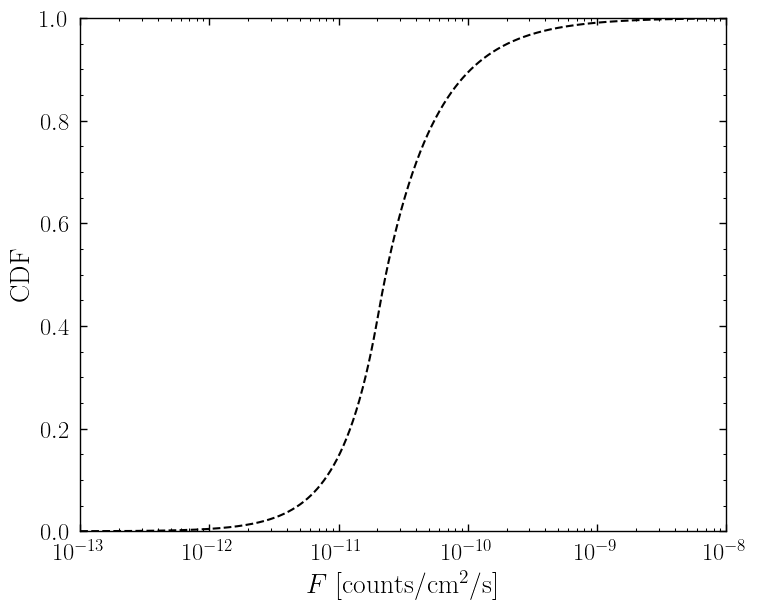

In [39]:
# Plot the associated CDF

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, CDF(Fv, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(0.,1.)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"CDF")
plt.show()

# Scenario 2

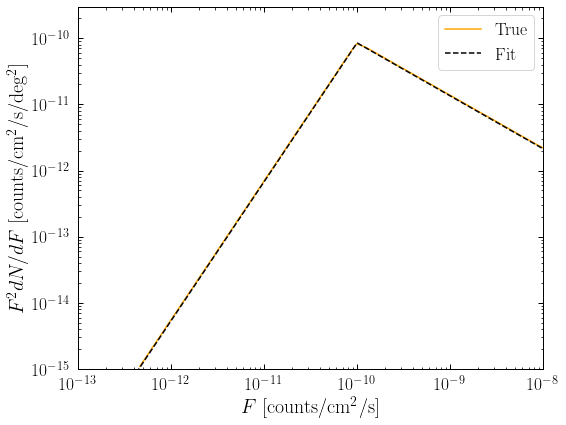

In [4]:
FsqdNdF2 = 10.**np.array([[-12.335419930041104,-14.959690101959689],[-12.293491702686469,-14.872697825384206],[-12.251563475331833,-14.784733568064864],[-12.209635247977198,-14.69676931074552],[-12.167707020622563,-14.608805053426178],[-12.125778793267928,-14.520354805734906],[-12.096953136961616,-14.462359954684583],[-12.04978388118765,-14.357818025789403],[-12.005235139623352,-14.267639812331268],[-11.963306912268717,-14.180647535755787],[-11.921378684914082,-14.092197288064515],[-11.879450457559447,-14.003747040373241],[-11.837522230204812,-13.917726744541618],[-11.795594002850176,-13.828304516106485],[-11.753665775495541,-13.740340258787143],[-11.711737548140906,-13.6523760014678],[-11.669809320786271,-13.564411744148458],[-11.627881093431636,-13.477419467572975],[-11.585952866077001,-13.388969219881702],[-11.55188618135136,-13.321124963960266],[-11.488993840319408,-13.184097278648071],[-11.444445098755107,-13.0915431122605],[-11.402516871400472,-13.003092864569227],[-11.363209158255502,-12.922001899652896],[-11.323901445110533,-12.839314109228795],[-11.281973217755898,-12.750863861537521],[-11.240044990401262,-12.663385594590109],[-11.198116763046627,-12.574935346898837],[-11.156188535691992,-12.487457079951422],[-11.114260308337357,-12.39900683226015],[-11.072332080982722,-12.310556584568879],[-11.035644882047416,-12.23587606408229],[-10.970132026805798,-12.094182871199568],[-10.925583285241498,-12.003410669509073],[-10.883655057886862,-11.91544641218973],[-10.841726830532227,-11.826996164498459],[-10.799798603177592,-11.739031907179116],[-10.757870375822957,-11.650581659487843],[-10.715942148468322,-11.56310339254043],[-10.674013921113687,-11.475139135221088],[-10.632085693759052,-11.387174877901746],[-10.590157466404417,-11.299210620582404],[-10.548229239049782,-11.21173235363499],[-10.506301011695147,-11.125712057803367],[-10.438167642243865,-10.980886926968207],[-10.39623941488923,-10.892922669648865],[-10.354311187534595,-10.803986431585662],[-10.31238296017996,-10.717480145382108],[-10.270454732825325,-10.629029897690836],[-10.23900856230935,-10.566337139711857],[-10.17873673548706,-10.434903743569881],[-10.134187993922762,-10.343267558995956],[-10.092259766568127,-10.254817311304683],[-10.050331539213492,-10.16733904435727],[-10.000541769229862,-10.082555814926923],[-9.895721200843274,-10.145822925163639],[-9.83806988823065,-10.19141765823926],[-9.780418575618029,-10.237719286401324],[-9.722767263005405,-10.28402091456339],[-9.665115950392781,-10.329969095182232],[-9.607464637780158,-10.375917275801076],[-9.549813325167534,-10.422925799049583],[-9.492162012554912,-10.468520532125204],[-9.434510699942289,-10.514115265200827],[-9.376859387329667,-10.560416893362891],[-9.319208074717043,-10.606718521524956],[-9.26155676210442,-10.652666702143799],[-9.203905449491796,-10.69861488276264],[-9.146254136879172,-10.744916510924707],[-9.088602824266548,-10.791571586629994],[-9.030951511653926,-10.836812872162392],[-8.973300199041303,-10.883114500324458],[-8.933992485896333,-10.914306246013787],[-8.847515516977397,-10.984553945229134],[-8.789864204364775,-11.029795230761533],[-8.732212891752152,-11.076096858923599],[-8.674561579139528,-11.12204503954244],[-8.616910266526904,-11.168346667704505],[-8.55925895391428,-11.214294848323348],[-8.501607641301657,-11.25988958139897],[-8.443956328689035,-11.306898104647479],[-8.386305016076411,-11.352139390179877],[-8.32865370346379,-11.398794465885164],[-8.271002390851166,-11.44509609404723],[-8.213351078238542,-11.491397722209294],[-8.155699765625918,-11.536992455284915],[-8.098048453013295,-11.58329408344698],[-8.040397140400671,-11.6288888165226],[-8.00633045567503,-11.653983592091354]])

# Guesses
Ag = 8.5e9
Fbg=1.e-10
n1g=2.8
n2g=-0.1

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

plt.plot(FsqdNdF2[:,0],FsqdNdF2[:,1],c='orange',label='True')

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, Fv**2.*dNdF(Fv, Ag, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(1.e-15,3.e-10)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"$F^2 dN/dF$ [counts/cm$^2$/s/deg$^2$]")
plt.legend(fontsize=22*rs)
plt.show()

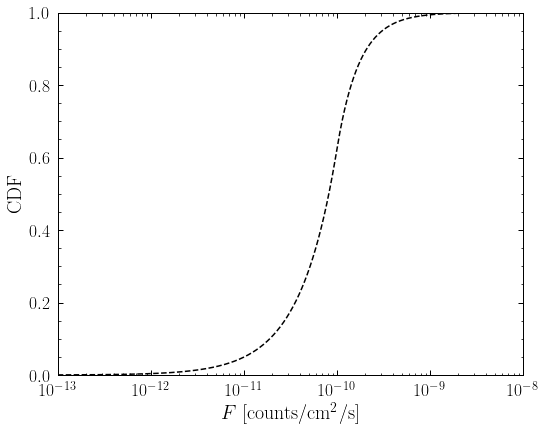

In [5]:
# Plot the associated CDF

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, CDF(Fv, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(0.,1.)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"CDF")
plt.show()

# Scenario 3

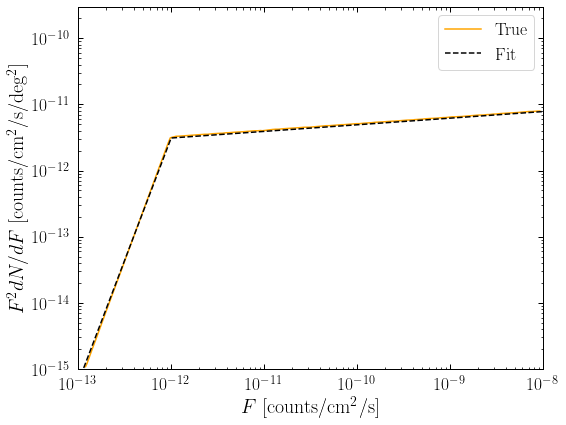

In [6]:
FsqdNdF3 = 10.**np.array([[-12.919441990368398,-14.964583185928173],[-12.90379530163967,-14.916661604035495],[-12.888163372545629,-14.855781062890083],[-12.872532919415056,-14.793604625819398],[-12.85950163795237,-14.74697451196159],[-12.849078383938384,-14.708115345765012],[-12.83605595825651,-14.653709856355563],[-12.823024676793825,-14.607079742497753],[-12.809996347258076,-14.557857836789395],[-12.794365894127504,-14.495681399718713],[-12.778731013106524,-14.437392650423849],[-12.763099084012483,-14.376512109278437],[-12.750070754476734,-14.32729020357008],[-12.737042424940986,-14.278068297861722],[-12.721410495846944,-14.217187756716314],[-12.705777090789434,-14.157603111496176],[-12.69014516169539,-14.096722570350765],[-12.677116832159644,-14.04750066464241],[-12.664087026660427,-13.999574654859327],[-12.648453621602917,-13.939990009639187],[-12.632820216545406,-13.880405364419051],[-12.617186811487896,-13.820820719198913],[-12.60416069589735,-13.769654969602646],[-12.5911301524164,-13.722376907782198],[-12.554654667221323,-13.581186242393091],[-12.539016834273406,-13.525489284948772],[-12.523384905179364,-13.46460874380336],[-12.507754452048792,-13.402432306732678],[-12.492121046991281,-13.34284766151254],[-12.479092717455533,-13.293625755804182],[-12.466064387919785,-13.244403850095827],[-12.450432458825743,-13.183523308950416],[-12.434797577804764,-13.125234559655551],[-12.421771462214219,-13.074068810059284],[-12.411348208200232,-13.035209643862709],[-12.398322092609687,-12.984043894266442],[-12.38529228711047,-12.936117884483359],[-12.374871247041687,-12.895314874398872],[-12.361843655487673,-12.84544502072788],[-12.346207298503225,-12.788452167358288],[-12.304521662264625,-12.626536022945618],[-12.288886781243646,-12.568247273650755],[-12.273254852149604,-12.507366732505343],[-12.260226522613856,-12.458144826796985],[-12.247199669041576,-12.407627025163356],[-12.231564788020597,-12.349338275868492],[-12.215934334890022,-12.287161838797807],[-12.200299453869045,-12.228873089502944],[-12.187270386351562,-12.180299131757224],[-12.174244270761015,-12.129133382160958],[-12.158610865703505,-12.06954873694082],[-12.142978936609463,-12.008668195795408],[-12.12995134505545,-11.958798342124416],[-12.119525877096262,-11.92188301981575],[-12.106499023523982,-11.87136521818212],[-12.090864142503003,-11.813076468887255],[-12.054388657307925,-11.671885803498146],[-12.041360327772178,-11.622663897789788],[-12.028330522272961,-11.574737888006705],[-12.007475453656873,-11.50453575198014],[-11.94731193556442,-11.48286654191487],[-11.915911550755508,-11.480975832711822],[-11.884513379891796,-11.477141279620866],[-11.860963644771413,-11.475237286746603],[-11.701352955296416,-11.458660741032771],[-11.66995552241444,-11.454178239979178],[-11.638555137605527,-11.452287530776132],[-11.60715253885141,-11.452340665460994],[-11.575755105969435,-11.447858164407402],[-11.557440613271538,-11.444649419827055],[-11.471092322478531,-11.43702016465879],[-11.450157256642454,-11.437055587782032],[-11.408295980751111,-11.429351058476875],[-11.376894857960464,-11.428108297236466],[-11.345497425078488,-11.423625796182874],[-11.321947689958105,-11.42172180330861],[-11.230365632706079,-11.414101403921155],[-11.162336262501372,-11.405793205557416],[-11.130938829619396,-11.401310704503823],[-11.099539182792217,-11.39877204733814],[-11.0681365840381,-11.398825182023003],[-11.036737675192658,-11.395638576894683],[-11.018415802677419,-11.398909311940702],[-10.93731013412424,-11.383495825439987],[-10.905912701242265,-11.379013324386394],[-10.87451379239682,-11.375826719258074],[-10.843111193642706,-11.375879853942937],[-10.811713022778996,-11.37204530085198],[-10.790782384833323,-11.368193036199402],[-10.701817210810805,-11.360568208921542],[-10.683499028204238,-11.36059920415438],[-10.628553336165346,-11.352916814301249],[-10.597154427319904,-11.34973020917293],[-10.565756256456194,-11.345895656081973],[-10.534354395683811,-11.3453008428042],[-10.510802446618225,-11.345340693817848],[-10.453239871349824,-11.337662731855124],[-10.393060412851913,-11.329989197782805],[-10.369512891676731,-11.326141361020634],[-10.330264071124493,-11.322320091600892],[-10.298861472370376,-11.322373226285755],[-10.267463301506666,-11.318538673194798],[-10.162801255997497,-11.30705272548355],[-10.14186619016142,-11.307088148606791],[-10.068603791479429,-11.298140858061227],[-10.037205620615719,-11.29430630497027],[-10.00580597378854,-11.291767647804587],[-9.974403375034425,-11.29182078248945],[-9.94300594215245,-11.287338281435858],[-9.922074566225042,-11.284133964745916],[-9.838343158661544,-11.276500281687245],[-9.804330318513529,-11.270726312598784],[-9.775546816934124,-11.268831175505332],[-9.744145694143477,-11.267588414264921],[-9.712747523279766,-11.263753861173964],[-9.689198526141118,-11.261201920337065],[-9.618551534725167,-11.25354609782637],[-9.59761646888909,-11.253581520949611],[-9.5243540702071,-11.244634230404046],[-9.492956637325126,-11.240151729350451],[-9.464173135745721,-11.238256592257],[-9.398755482898386,-11.234479601741311],[-9.377824844952714,-11.230627337088734],[-9.294093437389217,-11.222993654030063],[-9.260080597241199,-11.217219684941602],[-9.231297095661795,-11.21532454784815],[-9.199895972871149,-11.21408178660774],[-9.16849780200744,-11.210247233516784],[-9.139715038409769,-11.207704148460694],[-9.07430181345284,-11.200039470169187],[-9.050749864387253,-11.200079321182834],[-9.0062717052664,-11.192379219768084],[-8.97487353440269,-11.188544666677128],[-8.943470935648573,-11.18859780136199],[-8.91207202680313,-11.185411196233671],[-8.880670904012483,-11.18416843499326],[-8.849272733148773,-11.180333881902303],[-8.825724473991857,-11.177133993102768],[-8.755078958539375,-11.168182274666798],[-8.723680787675665,-11.164347721575842],[-8.692281140848486,-11.161809064410157],[-8.66087854209437,-11.16186219909502],[-8.62947889526719,-11.159323541929338],[-8.59808220036695,-11.154193092913108],[-8.577147134530874,-11.15422851603635],[-8.53528585863953,-11.146523986731195],[-8.509117026344434,-11.146568265635247],[-8.456788217535053,-11.138881447891713],[-8.425388570707874,-11.13634279072603],[-8.393990399844164,-11.132508237635072],[-8.362589277053516,-11.131265476394663],[-8.331188892244603,-11.129374767191617],[-8.299790721380893,-11.12554021410066],[-8.276240986260508,-11.123636221226397],[-8.216062265744332,-11.115314739191442],[-8.18466409488062,-11.111480186100486],[-8.153265186035178,-11.108293580972166],[-8.121862587281061,-11.108346715657028],[-8.090464416417351,-11.104512162566072],[-8.059064769590172,-11.10197350540039],[-8.035514296488055,-11.100717460488763]])

# Guesses
Ag = 3.1e12
Fbg=1.e-12
n1g=1.9
n2g=-1.7

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

plt.plot(FsqdNdF3[:,0],FsqdNdF3[:,1],c='orange',label='True')

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, Fv**2.*dNdF(Fv, Ag, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(1.e-15,3.e-10)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"$F^2 dN/dF$ [counts/cm$^2$/s/deg$^2$]")
plt.legend(fontsize=22*rs)
plt.show()

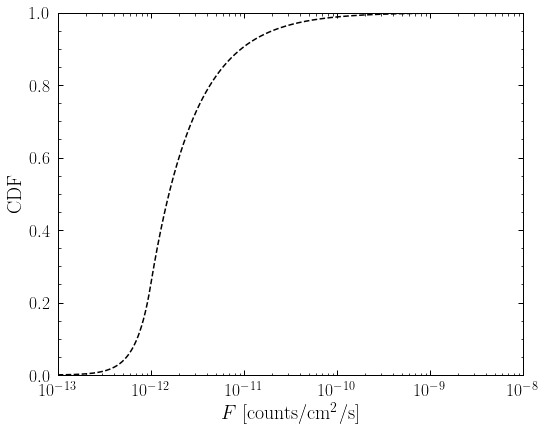

In [7]:
# Plot the associated CDF

fig, ax = plt.subplots(1, figsize=(10/1.2, 8/1.2))

Fv=np.logspace(-13,-8,1000)
plt.plot(Fv, CDF(Fv, Fbg, n1g, n2g),c='black',ls='--',label='Fit')

plt.xscale('log')
plt.xlim(1.e-13,1.e-8)
plt.ylim(0.,1.)
plt.xlabel(r"$F$ [counts/cm$^2$/s]")
plt.ylabel(r"CDF")
plt.show()